In [2]:
!pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly
!pip install -U --no-deps 'jax-triton[cuda11_pip] @ git+https://github.com/jax-ml/jax-triton.git'
#!pip install -Uq "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U --pre jax -f https://storage.googleapis.com/jax-releases/jax_nightly_releases.html

Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
  Cloning https://github.com/jax-ml/jax-triton.git to /var/tmp/pip-install-7uk5h467/jax-triton_39c8306368b74000ba20f15457f45cb1
  Running command git clone --filter=blob:none --quiet https://github.com/jax-ml/jax-triton.git /var/tmp/pip-install-7uk5h467/jax-triton_39c8306368b74000ba20f15457f45cb1
  Resolved https://github.com/jax-ml/jax-triton.git to commit 1f41ec21c8f0811794fd1fbfd69b22ba4a0cd034
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Looking in links: https://storage.googleapis.com/jax-releases/jax_nightly_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.8 MB/s eta 0:00:0000:01
  Attempting uninstall: jax
    Found existing installation: jax 0.4.19
    Uninstalling jax-0.4.19:
      Successfully uninstalled jax-0

In [55]:
from bayes3d.rendering.splat import splat, types, util
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import jax_triton
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

usage: 23.50%


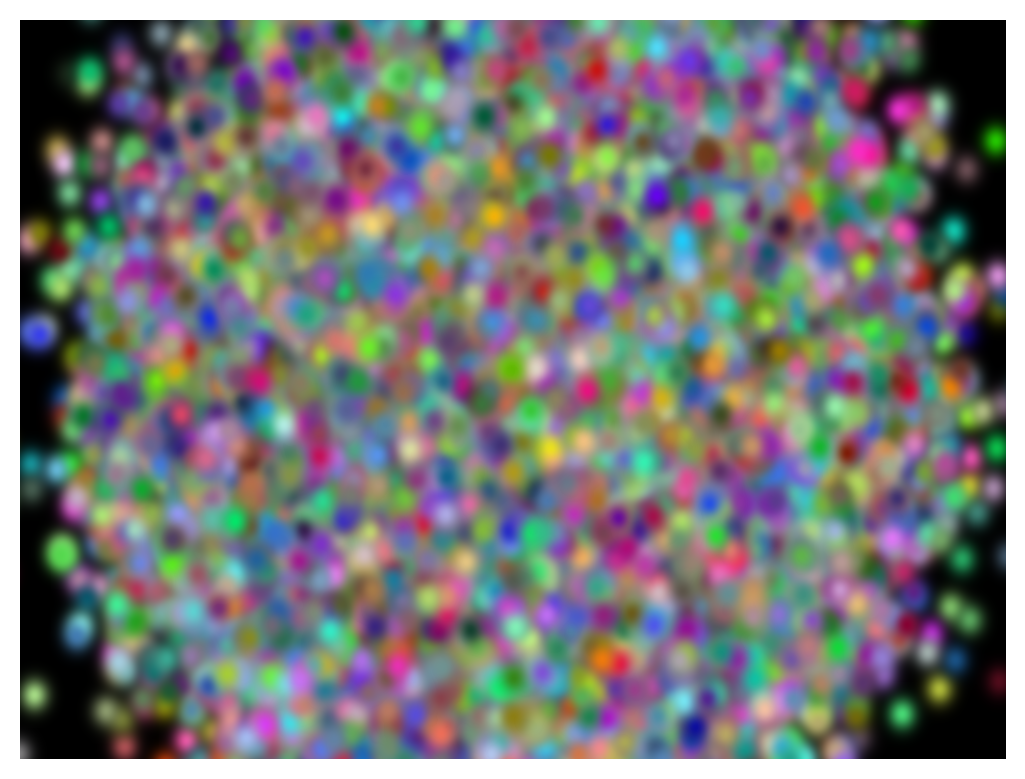

In [44]:
cam = types.Camera(xyz=jnp.array([0, 0, -256]), orientation=jnp.eye(3),
                   fx=2048., fy=2048.,
                   width=1024, height=768)
blobs = jax.vmap(lambda k: util.generate_random_blob(k, sph_harm_dim=1))(jr.split(jr.PRNGKey(0), 100_000))
blobs = blobs._replace(alpha=.75 + blobs.alpha * .25)
grid = types.Grid(types.Bounds(-30., 30., -20., 20.), nx=cam.width, ny=cam.height)
xys, _ = util.make_image_plane(grid)
im, aux = splat.render(xys, blobs=blobs, camera=cam, grid=grid, workspace_dim=10_000_000)
assert 0 < aux['workspace_occupancy'] < 1., aux['workspace_occupancy']
print(f'usage: {100*aux["workspace_occupancy"]:.2f}%')
plt.imshow(im, origin='lower')
plt.axis('off');

usage: 0.05%


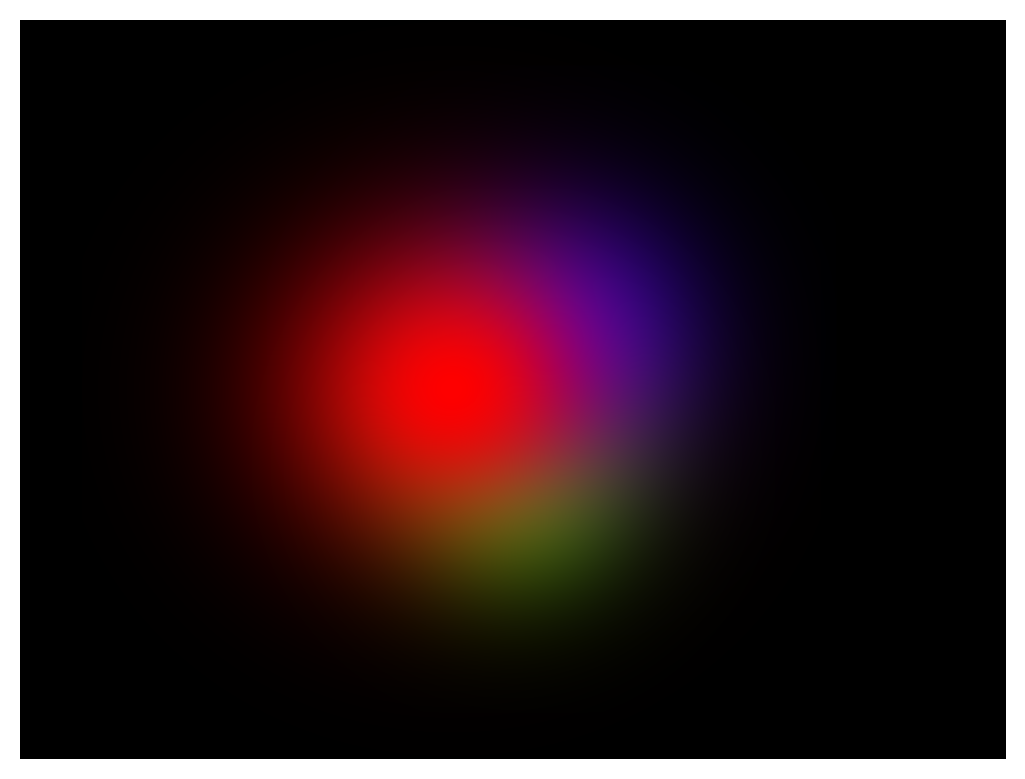

In [60]:
RGB2SH = lambda rgb: (rgb - .5) / .28209
blob1 = types.Blob(xyz=jnp.array([-.5, 0., 1.]),
             cov=jnp.eye(3)/2,
             color=RGB2SH(jnp.array([[1., 0., 0.]])),
             alpha=1.)
blob2 = types.Blob(xyz=jnp.array([.5, .5, 1.5]),
             cov=jnp.eye(3)/2,
             color=RGB2SH(jnp.array([[0., 0., 1]])),
             alpha=1.)
blob3 = types.Blob(xyz=jnp.array([0., -1, 2.]),
             cov=jnp.eye(3)/2,
             color=RGB2SH(jnp.array([[0, 1, 0.]])),
             alpha=1.)

blobs = jtu.tree_map(lambda *xs: jnp.stack(xs), blob1, blob2, blob3)

cam = types.Camera(xyz=jnp.array([0, 0, 0.]), orientation=jnp.eye(3),
                   fx=1., fy=1.,
                   width=1024, height=768)
grid = types.Grid(types.Bounds(-4., 4., -3., 3.), nx=cam.width, ny=cam.height)
xys, _ = util.make_image_plane(grid)
target_im, aux = splat.render(xys, blobs=blobs, camera=cam, grid=grid, workspace_dim=10_000_000)
assert 0 < aux['workspace_occupancy'] < 1., aux['workspace_occupancy']
print(f'usage: {100*aux["workspace_occupancy"]:.2f}%')
plt.imshow(target_im, origin='lower')
plt.axis('off');

100%|█████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:15<00:00, 197.71it/s, loss=199.13306]


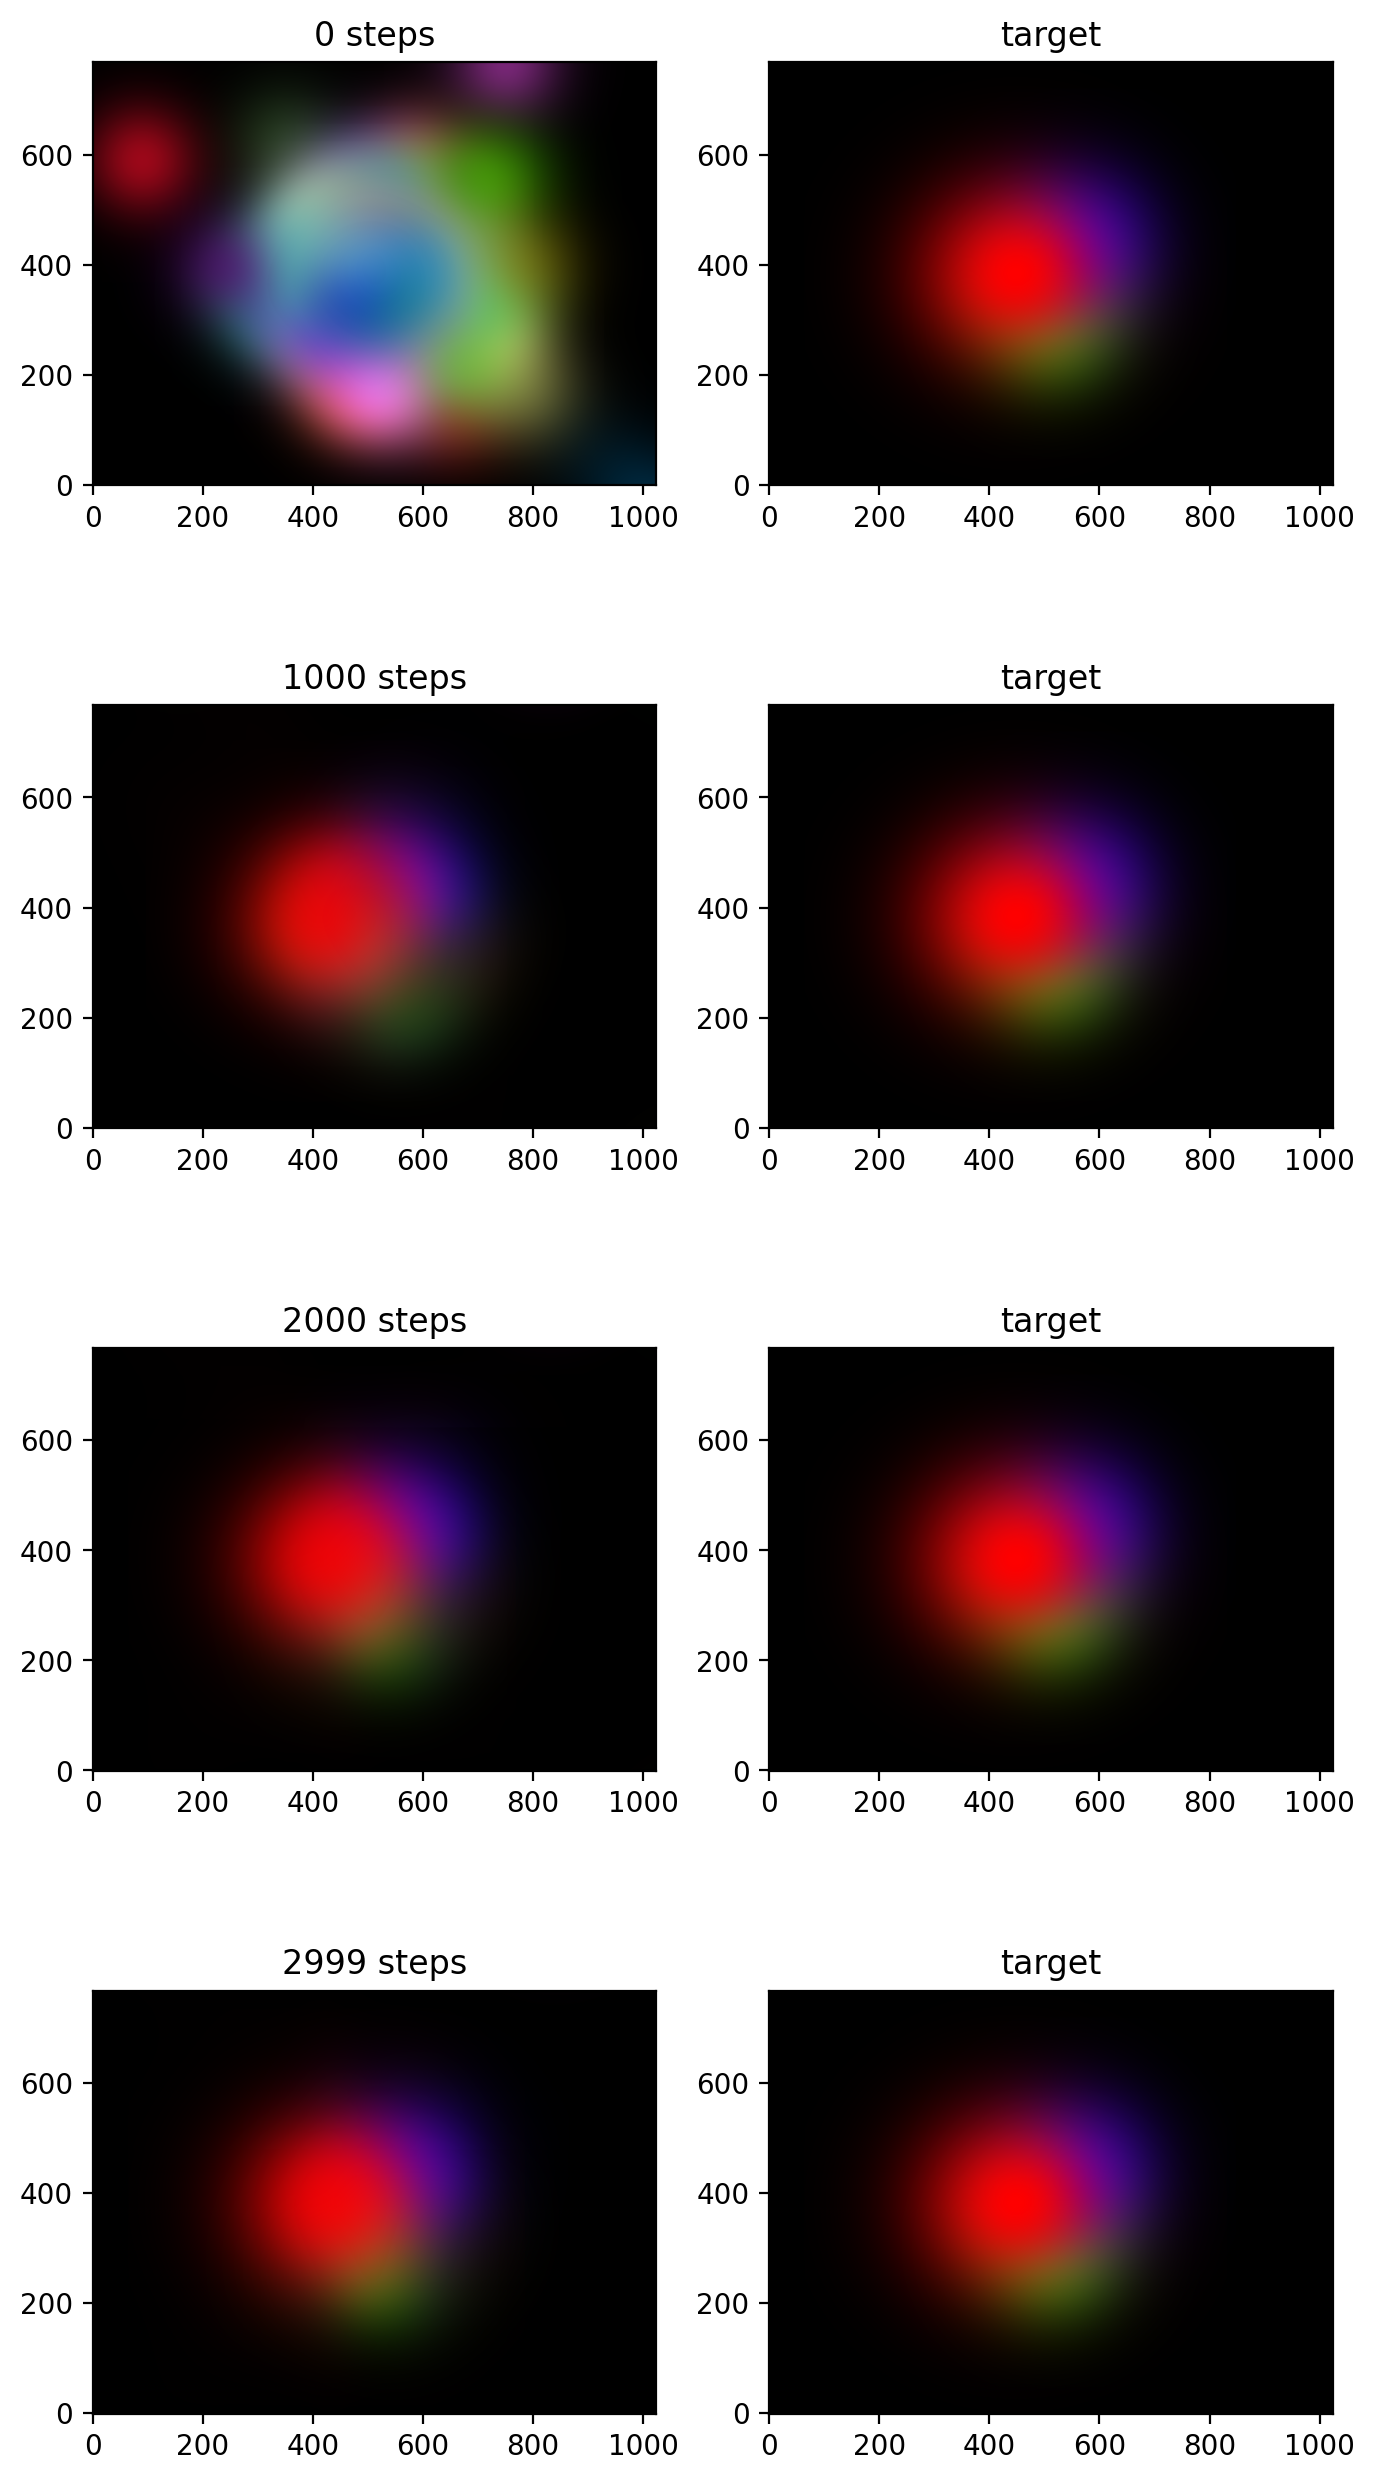

In [66]:
import numpy as np
import optax
import tensorflow_probability.substrates.jax as tfp
import tqdm

tfb = tfp.bijectors
bijs = types.Blob(xyz=tfb.Identity(),
                  cov=tfb.CholeskyOuterProduct()(tfb.FillScaleTriL()),
                  color=tfb.Identity(),
                  alpha=tfb.Sigmoid())
def unconstrain(blobs):
  return jtu.tree_map(lambda b, t: b.inverse(t), bijs, blobs, is_leaf=lambda t:isinstance(t, (tfb.Bijector, jax.Array)))
def constrain(blobs):
  return jtu.tree_map(lambda b, t: b(t), bijs, blobs, is_leaf=lambda t:isinstance(t, (tfb.Bijector, jax.Array)))


@jax.jit
@jax.value_and_grad
def value_and_grad_fn(blobs):
  blobs = constrain(blobs)
  return ((splat.render(xys, blobs=blobs, camera=cam, grid=grid, workspace_dim=100_000)[0] - target_im)**2).sum()

@jax.jit
def update(blobs, opt_state):
  loss, grad = value_and_grad_fn(blobs)
  updates, opt_state = opt.update(grad, opt_state)
  blobs = optax.apply_updates(blobs, updates)
  return loss, blobs, opt_state


blobs = unconstrain(jax.vmap(util.generate_random_blob)(jr.split(jr.PRNGKey(2023), 500)))
opt = optax.adam(.001)
opt_state = opt.init(blobs)

history = []

import tqdm
niters=3_000
it = tqdm.tqdm(range(niters))
for i in it:
  loss, blobs, opt_state = update(blobs, opt_state)
  it.set_postfix(loss=loss)
  if i % 1_000 == 0 or i == niters - 1:
    history.append((i, splat.render(xys, blobs=constrain(blobs), camera=cam, grid=grid, workspace_dim=100_000)[0]))

_, axes = plt.subplots(len(history), 2, figsize=(8, 4 * len(history)))
for ax, (i, im) in zip(np.array(axes).reshape(-1, 2)[:, 0], history):
  ax.imshow(im, origin='lower')
  ax.set_title(f'{i} steps')
for ax in np.array(axes).reshape(-1, 2)[:, 1]:
  ax.imshow(target_im, origin='lower')
  ax.set_title('target')
plt.show()